In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install pycaret

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [5]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.6 MB/s eta 0:00:00


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
# import shap

In [13]:
# Load dataset
file_path = "/content/drive/MyDrive/Weather-health/fp-historical-wildfire-data-2006-2023.csv"
data = pd.read_csv(file_path)


# Select columns that have nan value under 3000.
missing_data_count = data.isnull().sum()
valid_columns = [col for col in missing_data_count[missing_data_count < 3000].index.tolist()]

# Selected columns by problem formulation
selected_columns = [
    'fire_location_latitude', 'fire_location_longitude', 'reported_date',
    'dispatch_date', 'start_for_fire_date', 'assessment_datetime',
    'assessment_resource', 'assessment_hectares', 'fire_spread_rate',
    'fire_type', 'fire_position_on_slope', 'weather_conditions_over_fire',
    'temperature', 'relative_humidity', 'wind_direction', 'wind_speed',
    'fuel_type', 'initial_action_by', 'ia_arrival_at_fire_date',
    'fire_fighting_start_date', 'fire_fighting_start_size', 'ia_access',
    'bucketing_on_fire', 'distance_from_water_source', 'ex_fs_date',
    'current_size'
]

# Comparison between valid columns and selected columns
valid_columns_set = set(valid_columns)
selected_columns_set = set(selected_columns)
intersection_columns = valid_columns_set.intersection(selected_columns_set)
missing_columns = selected_columns_set.difference(valid_columns_set)

print("Columns available in both sets:", intersection_columns)
print("Columns missing in the valid columns set:", missing_columns)

# Use intersection of both sets
data_clean = data[list(intersection_columns)].dropna()

# convert the time columns of dataset as datetime type
time_columns = ['reported_date', 'dispatch_date', 'start_for_fire_date', 'assessment_datetime', 'ia_arrival_at_fire_date', 'fire_fighting_start_date', 'ex_fs_date']
timeformat = "%Y-%m-%d %H:%M:%S"

for col in time_columns:
    if col in data_clean.columns:
        data_clean[col] = pd.to_datetime(data_clean[col], format=timeformat)

# Seasonal information
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10]:
        return 'Autumn'
    else:
        return 'Winter'

if 'reported_date' in data_clean.columns:
    data_clean['season'] = data_clean['reported_date'].dt.month.apply(get_season)

# region information by fire number code
region_map = {
    'C': 'Calgary', 'E': 'Edson', 'H': 'High Level', 'G': 'Grande Prairie',
    'L': 'Lac La Biche', 'M': 'Fort McMurray', 'P': 'Peace River',
    'R': 'Rocky', 'S': 'Slave Lake', 'W': 'Whitecourt'
}
if 'fire_number' in data.columns:
    data_clean['fire_region'] = data['fire_number'].str[0].map(region_map)

# Compuation of fire duration time [hour]
data_clean['fire_duration'] = (data_clean['ex_fs_date'] - data_clean['reported_date']).dt.total_seconds() / 3600  # 시간 단위로 변환

# The time gap for dispatch, start-report, and assessment-report [hour]
data_clean["dispatch_gap"] = (
    data_clean["dispatch_date"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0
data_clean["start_for_fire_gap"] = (
    data_clean["start_for_fire_date"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0
data_clean["assessment_gap"] = (
    data_clean["assessment_datetime"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0

for col in time_columns:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].map(pd.Timestamp.timestamp)

# Encoding categorical variables
categorical_columns = data_clean.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_clean[col] = le.fit_transform(data_clean[col])
    label_encoders[col] = le

if 'ex_fs_date' in data_clean.columns:
    data_clean.drop(columns=['ex_fs_date'], inplace=True)



Columns available in both sets: {'dispatch_date', 'weather_conditions_over_fire', 'fire_position_on_slope', 'assessment_resource', 'wind_speed', 'assessment_datetime', 'ex_fs_date', 'fire_location_latitude', 'start_for_fire_date', 'fire_spread_rate', 'fire_location_longitude', 'wind_direction', 'initial_action_by', 'current_size', 'reported_date', 'assessment_hectares', 'relative_humidity', 'fire_type', 'temperature'}
Columns missing in the valid columns set: {'fire_fighting_start_date', 'ia_arrival_at_fire_date', 'fuel_type', 'ia_access', 'bucketing_on_fire', 'fire_fighting_start_size', 'distance_from_water_source'}


In [6]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [14]:
y_duration_log = np.log1p(data_clean['fire_duration'] + 1e-9)
y_size_log = np.log1p(data_clean['current_size'] + 1e-9)
X_log = np.log1p(data_clean.drop(columns=['fire_duration', 'current_size']) + 1e-9)

# Data Normalization
#scaler = StandardScaler()
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(data_clean.drop(columns=['fire_duration', 'current_size']))
y_duration_scaled = scaler.fit_transform(y_duration_log.values.reshape(-1, 1))
y_size_scaled = scaler.fit_transform(y_size_log.values.reshape(-1, 1))


# Create Train and Target Data
X = pd.DataFrame(X_scaled, columns=data_clean.drop(columns=['fire_duration', 'current_size']).columns)
y_duration = pd.DataFrame(y_duration_scaled, columns=['fire_duration'])
y_size = pd.DataFrame(y_size_scaled, columns=['current_size'])

# Split Dataset
X_train, X_test, y_train_duration, y_test_duration = train_test_split(X, y_duration, test_size=0.2, random_state=42)
_, _, y_train_size, y_test_size = train_test_split(X, y_size, test_size=0.2, random_state=42)

# Convert as Tensor for model traning
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_duration_tensor = torch.tensor(y_train_duration.values, dtype=torch.float32).view(-1, 1)
y_test_duration_tensor = torch.tensor(y_test_duration.values, dtype=torch.float32).view(-1, 1)
y_train_size_tensor = torch.tensor(y_train_size.values, dtype=torch.float32).view(-1, 1)
y_test_size_tensor = torch.tensor(y_test_size.values, dtype=torch.float32).view(-1, 1)

# DataLoader
train_dataset_duration = TensorDataset(X_train_tensor, y_train_duration_tensor)
test_dataset_duration = TensorDataset(X_test_tensor, y_test_duration_tensor)
train_loader_duration = DataLoader(train_dataset_duration, batch_size=64, shuffle=True)
test_loader_duration = DataLoader(test_dataset_duration, batch_size=64, shuffle=False)

train_dataset_size = TensorDataset(X_train_tensor, y_train_size_tensor)
test_dataset_size = TensorDataset(X_test_tensor, y_test_size_tensor)
train_loader_size = DataLoader(train_dataset_size, batch_size=64, shuffle=True)
test_loader_size = DataLoader(test_dataset_size, batch_size=64, shuffle=False)




/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,Description,Value
0,Session id,123
1,Target,fire_duration
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(15713, 23)"
6,Transformed test set shape,"(6735, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1083,0.0190,0.1379,0.4961,0.1043,0.9875,2.0110
et,Extra Trees Regressor,0.1078,0.0194,0.1391,0.4876,0.1050,0.9299,8.5740
xgboost,Extreme Gradient Boosting,0.1094,0.0201,0.1416,0.4688,0.1069,0.9745,0.3830
rf,Random Forest Regressor,0.1107,0.0201,0.1418,0.4671,0.1072,0.9470,20.8470
gbr,Gradient Boosting Regressor,0.1152,0.0207,0.1439,0.4512,0.1089,1.1325,4.8560
ridge,Ridge Regression,0.1450,0.0307,0.1752,0.1868,0.1328,1.8330,0.0290
br,Bayesian Ridge,0.1447,0.0307,0.1752,0.1868,0.1325,1.8216,0.0590
lr,Linear Regression,0.1447,0.0307,0.1753,0.1862,0.1325,1.8195,0.4830
huber,Huber Regressor,0.1434,0.0316,0.1778,0.1626,0.1319,1.6499,0.5110
knn,K Neighbors Regressor,0.1425,0.0322,0.1795,0.1469,0.1361,1.4265,0.1270


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1164,0.0216,0.1469,0.4429,0.1107,1.0356
1,0.1150,0.0204,0.1427,0.4756,0.1077,1.1126
2,0.1155,0.0209,0.1447,0.4290,0.1088,1.3103
3,0.1119,0.0191,0.1383,0.4658,0.1056,1.0147
4,0.1127,0.0200,0.1414,0.4631,0.1077,1.1193
5,0.1152,0.0213,0.1459,0.4137,0.1106,1.0252
6,0.1165,0.0221,0.1488,0.4446,0.1124,1.2402
7,0.1190,0.0226,0.1502,0.4067,0.1126,0.9670
8,0.1157,0.0213,0.1459,0.4471,0.1094,1.1767


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0990,0.0156,0.1249,0.5828,0.0951,0.9201


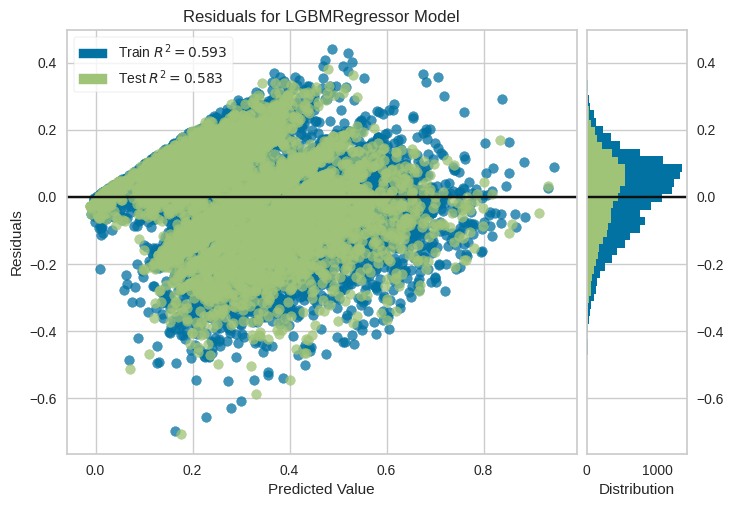

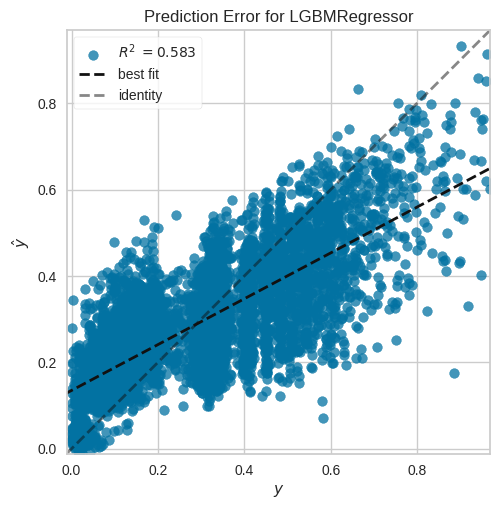

R²of fire_duration_regression:                              Model    MAE     MSE    RMSE      R2   RMSLE  \
0  Light Gradient Boosting Machine  0.099  0.0156  0.1249  0.5828  0.0951   

     MAPE  
0  0.9201  


In [22]:
import pandas as pd
import numpy as np
from pycaret.regression import *

'''
Wild fire duration regression
'''

# PyCaret setup
data_for_pycaret = pd.concat([X, y_duration], axis=1)
duration_reg = setup(data=data_for_pycaret, target='fire_duration', session_id=123,experiment_name='fire_duration_regression')

# Model comparison and best model selection
best_model = compare_models()

best_tune = tune_model(best_model)

# Best model training and evaluation
final_model = finalize_model(best_tune)

# Model prediction
predictions = predict_model(final_model)

# Model evaluation
plot_model(final_model, plot='residuals')
plot_model(final_model, plot='error')

# R² score
r2 = pull()
print(f"R²of fire_duration_regression: {r2}")

,Description,Value
0,Session id,123
1,Target,current_size
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(15713, 23)"
6,Transformed test set shape,"(6735, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0211,0.0034,0.0585,0.6130,0.0460,1.4461,1.5560
gbr,Gradient Boosting Regressor,0.0219,0.0035,0.0587,0.6113,0.0462,1.6506,4.9080
et,Extra Trees Regressor,0.0221,0.0035,0.0594,0.6014,0.0470,1.8342,6.6430
rf,Random Forest Regressor,0.0224,0.0036,0.0603,0.5906,0.0478,1.7165,23.3020
xgboost,Extreme Gradient Boosting,0.0234,0.0038,0.0615,0.5728,0.0487,1.8306,0.3660
ridge,Ridge Regression,0.0417,0.0064,0.0796,0.2844,0.0644,4.9129,0.0310
br,Bayesian Ridge,0.0410,0.0064,0.0797,0.2833,0.0639,4.7784,0.0330
lr,Linear Regression,0.0409,0.0064,0.0797,0.2825,0.0639,4.7727,0.0320
dt,Decision Tree Regressor,0.0284,0.0071,0.0843,0.1961,0.0664,1.9648,0.4770
huber,Huber Regressor,0.0313,0.0073,0.0852,0.1798,0.0684,1.7613,0.3370


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0227,0.0036,0.0602,0.5706,0.0472,1.4900
1,0.0242,0.0046,0.0682,0.5305,0.0527,1.5163
2,0.0230,0.0036,0.0596,0.5988,0.0470,1.7541
3,0.0230,0.0035,0.0592,0.5809,0.0469,1.8252
4,0.0215,0.0035,0.0589,0.5861,0.0462,1.6473
5,0.0224,0.0038,0.0614,0.5622,0.0482,1.7083
6,0.0239,0.0043,0.0657,0.5843,0.0507,1.4350
7,0.0221,0.0033,0.0579,0.5846,0.0461,1.4113
8,0.0239,0.0042,0.0652,0.5712,0.0511,1.5065


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0161,0.0019,0.0432,0.7917,0.0342,1.1297


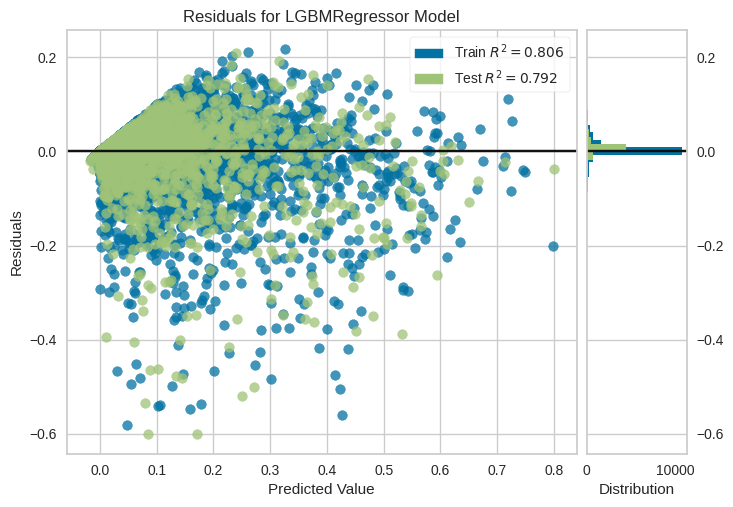

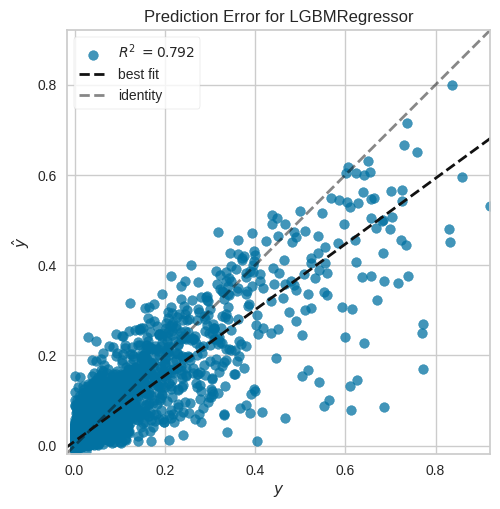

R²of fire_size_regression:                              Model     MAE     MSE    RMSE      R2   RMSLE  \
0  Light Gradient Boosting Machine  0.0161  0.0019  0.0432  0.7917  0.0342   

     MAPE  
0  1.1297  


In [26]:
'''
Wild fire size regression
'''

data_for_pycaret = pd.concat([X, y_size], axis=1)
size_reg = setup(data=data_for_pycaret, target='current_size', session_id=123, experiment_name='fire_size_regression')

best_model = compare_models()

final_model = finalize_model(best_model)
best_tune = tune_model(best_model)

predictions = predict_model(final_model)

plot_model(final_model, plot='residuals')
plot_model(final_model, plot='error')

r2 = pull()
print(f"R²of fire_size_regression: {r2}")

In [39]:
'''
Feed Forward Model
'''
class SimpleFirePredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleFirePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Model Initialization
input_dim = X_train_tensor.shape[1]
model_duration = SimpleFirePredictionModel(input_dim).to(device)
model_size = SimpleFirePredictionModel(input_dim).to(device)

# Loss function
criterion =[nn.L1Loss(), nn.MSELoss()]

# Optimizer
optimizer_duration = optim.Adam(model_duration.parameters(), lr=0.001)
optimizer_size = optim.Adam(model_size.parameters(), lr=0.001)

In [57]:
'''
Convolution + Long ShortTerm Memory Model
(CNN + LSTM)
'''
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, seq_length)
        x = self.pool(torch.relu(self.conv1(x)))  # (batch_size, 32, seq_length/2)
        x = x.permute(0, 2, 1)  # (batch_size, seq_length/2, 32)
        x, _ = self.lstm(x)  # (batch_size, seq_length/2, 64)
        x = self.dropout(torch.relu(self.fc1(x[:, -1, :])))  # (batch_size, 32)
        x = self.fc2(x)  # (batch_size, 1)
        return x

# Model Initialization
input_dim = X_train_tensor.shape[1]
model_duration_cnnlstm = CNNLSTMModel(input_dim).to(device)
model_size_cnnlstm  = CNNLSTMModel(input_dim).to(device)

# Loss function
criterion =[nn.L1Loss(), nn.MSELoss()]

# Optimizer
optimizer_duration_cnnlstm = optim.Adam(model_duration_cnnlstm.parameters(), lr=0.001)
optimizer_size_cnnlstm = optim.Adam(model_size_cnnlstm.parameters(), lr=0.001)


In [58]:
# Model training code
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = criterion(outputs, targets)
            loss1 = criterion[0](outputs, targets)
            loss2 = criterion[1](outputs, targets)
            loss = loss1+loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return model, train_losses

# Model evaluation code
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss1 = criterion[0](outputs, targets)
            loss2 = criterion[1](outputs, targets)
            loss = loss1+loss2
            total_loss += loss.item()
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return avg_loss, np.array(actuals), np.array(predictions)

# visualization
def plot_predictions(actuals, predictions, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

# R² score
def calculate_r2(actuals, predictions, title):
    r2 = r2_score(actuals, predictions)
    print(f'{title} - R²: {r2:.4f}')


Training duration model...
Epoch [5/100], Loss: 0.1712
Epoch [10/100], Loss: 0.1645
Epoch [15/100], Loss: 0.1605
Epoch [20/100], Loss: 0.1574
Epoch [25/100], Loss: 0.1556
Epoch [30/100], Loss: 0.1545
Epoch [35/100], Loss: 0.1531
Epoch [40/100], Loss: 0.1524
Epoch [45/100], Loss: 0.1512
Epoch [50/100], Loss: 0.1510
Epoch [55/100], Loss: 0.1497
Epoch [60/100], Loss: 0.1495
Epoch [65/100], Loss: 0.1492
Epoch [70/100], Loss: 0.1487
Epoch [75/100], Loss: 0.1481
Epoch [80/100], Loss: 0.1474
Epoch [85/100], Loss: 0.1479
Epoch [90/100], Loss: 0.1473
Epoch [95/100], Loss: 0.1457
Epoch [100/100], Loss: 0.1461
Evaluating wildfire duration model...
Wildfire Duration Model - Loss: 0.1432
Training size model...
Epoch [5/100], Loss: 0.0395
Epoch [10/100], Loss: 0.0375
Epoch [15/100], Loss: 0.0361
Epoch [20/100], Loss: 0.0353
Epoch [25/100], Loss: 0.0346
Epoch [30/100], Loss: 0.0341
Epoch [35/100], Loss: 0.0339
Epoch [40/100], Loss: 0.0337
Epoch [45/100], Loss: 0.0332
Epoch [50/100], Loss: 0.0330
Epoc

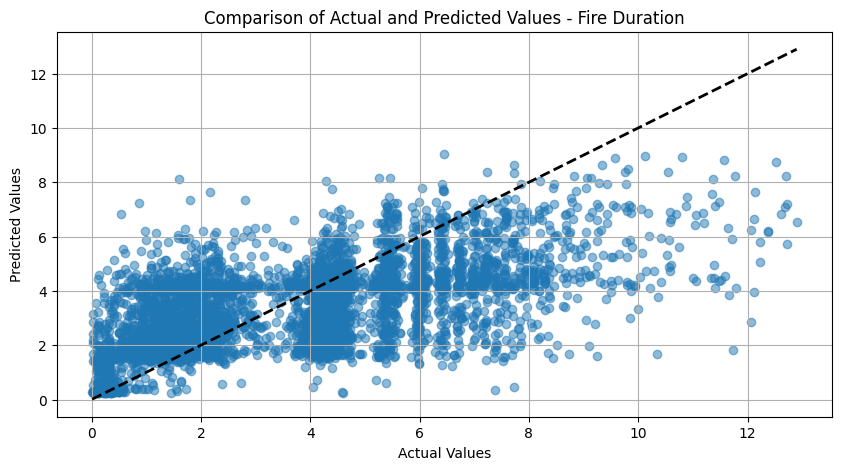

Fire Duration - R²: 0.3303


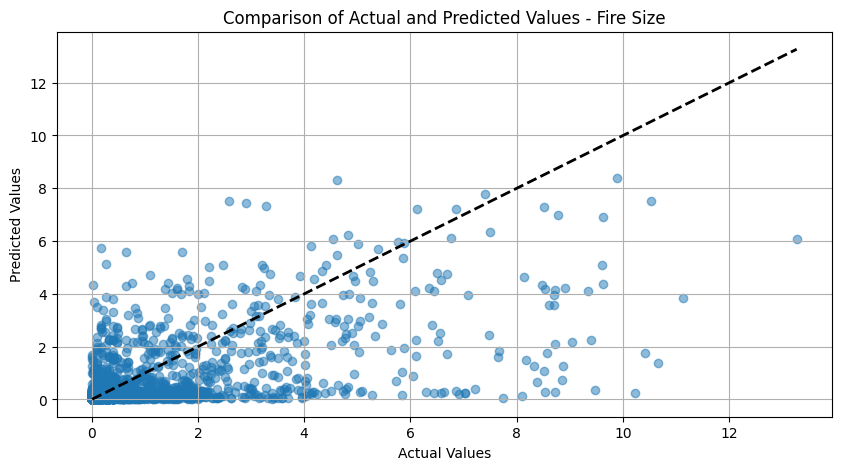

Fire Size - R²: 0.3783


In [41]:
print("Feedforward Neural Network (FNN)")
# Wildfire duration prediction model training
print("Training duration model...")
model_duration, train_losses_duration = train_model(model_duration, train_loader_duration, criterion, optimizer_duration)

print("Evaluating wildfire duration model...")
duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration, test_loader_duration, criterion)
print("Wildfire Duration Model - Loss: %.4f"%duration_loss )

# Wildfire size prediction model training
print("Training size model...")
model_size, train_losses_size = train_model(model_size, train_loader_size, criterion, optimizer_size)

print("Evaluating wildfire size model...")
size_loss, actuals_size, predictions_size = evaluate_model(model_size, test_loader_size, criterion)
print(f"Wildfire Size Model - Loss: %.4f"%size_loss)

# Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Comparison of Actual and Predicted Values - Fire Duration')
calculate_r2(actuals_duration, predictions_duration, 'R²score of Fire Duration Model (FNN)')

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, 'Comparison of Actual and Predicted Values - Fire Size')
calculate_r2(actuals_size, predictions_size, 'R²score of Fire Size Model (FNN)')


Training duration CNNLSTM model...
Epoch [5/100], Loss: 0.1684
Epoch [10/100], Loss: 0.1656
Epoch [15/100], Loss: 0.1629
Epoch [20/100], Loss: 0.1604
Epoch [25/100], Loss: 0.1591
Epoch [30/100], Loss: 0.1570
Epoch [35/100], Loss: 0.1544
Epoch [40/100], Loss: 0.1545
Epoch [45/100], Loss: 0.1522
Epoch [50/100], Loss: 0.1499
Epoch [55/100], Loss: 0.1480
Epoch [60/100], Loss: 0.1458
Epoch [65/100], Loss: 0.1456
Epoch [70/100], Loss: 0.1428
Epoch [75/100], Loss: 0.1409
Epoch [80/100], Loss: 0.1381
Epoch [85/100], Loss: 0.1350
Epoch [90/100], Loss: 0.1318
Epoch [95/100], Loss: 0.1279
Epoch [100/100], Loss: 0.1230
Evaluating wildfire duration CNNLSTM model...
Wildfire CNNLSTMDuration Model - Loss: 0.1536
Training size CNNLSTM model...
Epoch [5/100], Loss: 0.0459
Epoch [10/100], Loss: 0.0454
Epoch [15/100], Loss: 0.0377
Epoch [20/100], Loss: 0.0364
Epoch [25/100], Loss: 0.0350
Epoch [30/100], Loss: 0.0347
Epoch [35/100], Loss: 0.0341
Epoch [40/100], Loss: 0.0336
Epoch [45/100], Loss: 0.0335
Ep

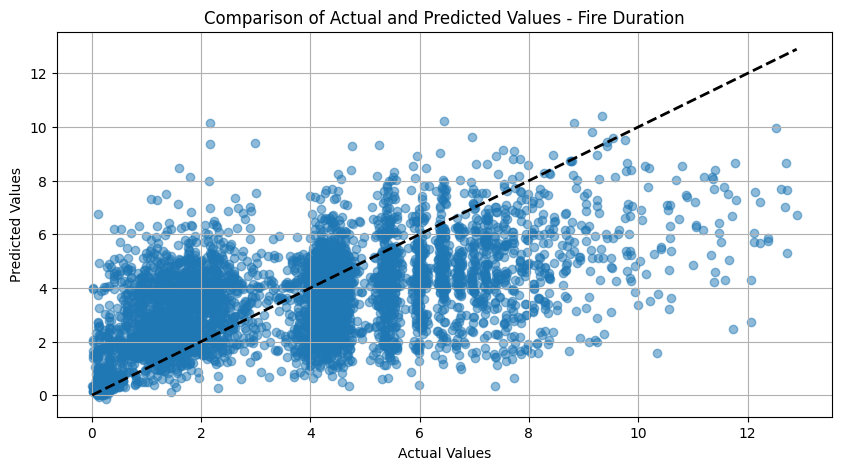

Fire Duration - R²: 0.2549


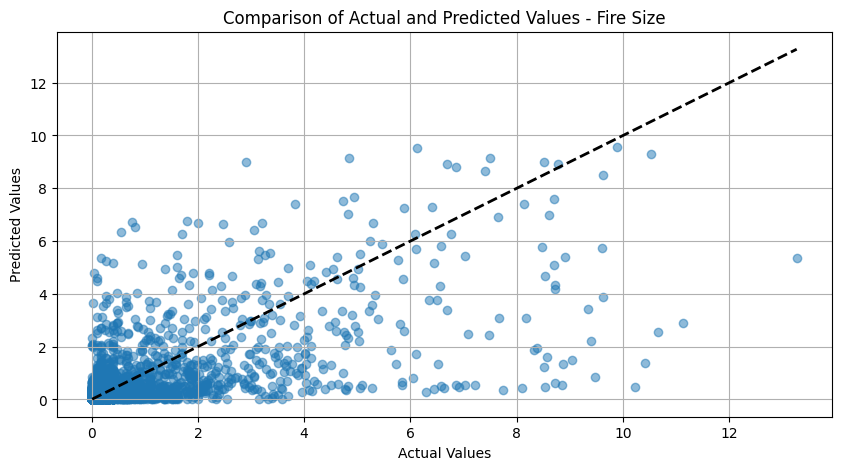

Fire Size - R²: 0.4041


In [62]:
print("Model: CNN(Convolutional Neural Network)+ LSTM(Long Short Term Memory)")

# Wildfire duration prediction model training
print("\ Training duration CNNLSTM model...")
model_duration, train_losses_duration = train_model(model_duration_cnnlstm, train_loader_duration, criterion, optimizer_duration_cnnlstm)

print("\ Evaluating wildfire duration CNNLSTM model...")
duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration_cnnlstm, test_loader_duration, criterion)
print("\ Wildfire CNNLSTMDuration Model - Loss: %.4f"%duration_loss )

# Wildfire size prediction model training
print("\ Training size CNNLSTM model...")
model_size, train_losses_size = train_model(model_size_cnnlstm, train_loader_size, criterion, optimizer_size_cnnlstm)

print("\ Evaluating wildfire size CNNLSTM model...")
size_loss, actuals_size, predictions_size = evaluate_model(model_size, test_loader_size, criterion)
print("\ Wildfire CNNLSTM Size Model - Loss: %.4f"%size_loss)

# Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Comparison of Actual and Predicted Values - Fire Duration')
calculate_r2(actuals_duration, predictions_duration, '\ R²score of Fire Duration Model (CNNLSTM)')

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, '\ Comparison of Actual and Predicted Values - Fire Size')
calculate_r2(actuals_size, predictions_size,  '\ R²score of Fire Size Model (CNNLSTM')

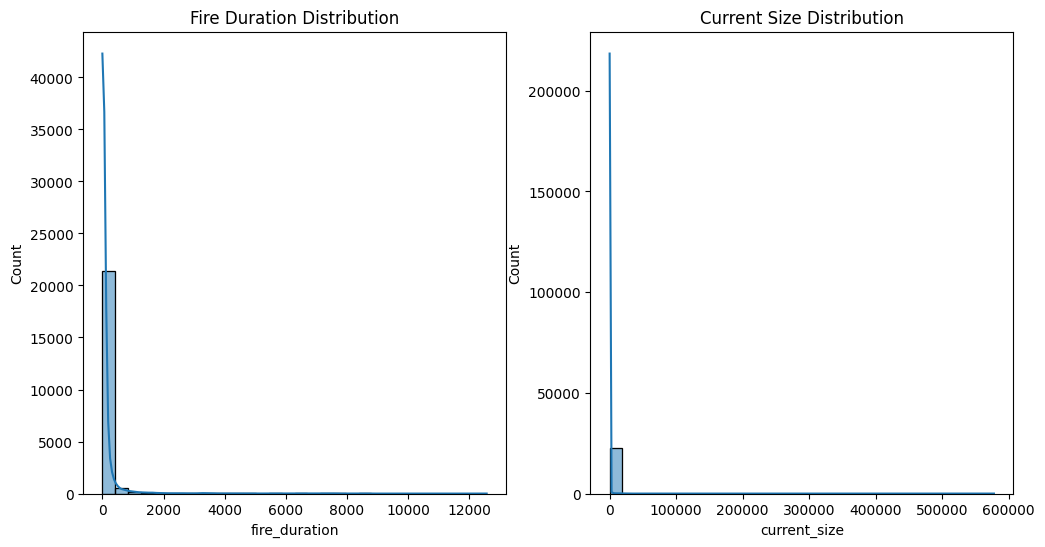

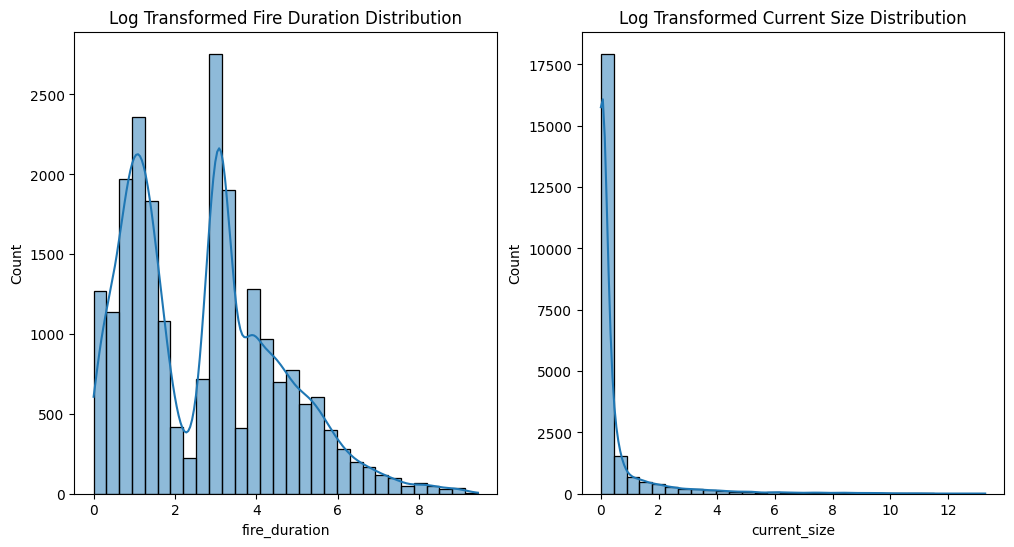

In [33]:
import seaborn as sns

# Distribution of Target features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_clean['fire_duration'], bins=30, kde=True)
plt.title('Fire Duration Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data_clean['current_size'], bins=30, kde=True)
plt.title('Current Size Distribution')

plt.show()

# Distribution of Target features after log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(np.log1p(data_clean['fire_duration'] + 1e-9), bins=30, kde=True)
plt.title('Log Transformed Fire Duration Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data_clean['current_size'] + 1e-9), bins=30, kde=True)
plt.title('Log Transformed Current Size Distribution')

plt.show()


In [ ]:
import shap

# SHAP을 사용한 특징 중요도 분석
def shap_feature_importance(model, data, title):
    # SHAP explainer 초기화
    explainer = shap.DeepExplainer(model, data.to(device))
    shap_values = explainer.shap_values(data.to(device))

    # 특징 중요도 시각화
    shap.summary_plot(shap_values, data.cpu(), plot_type="bar", feature_names=data.columns, show=False)
    plt.title(title)
    plt.show()

# SHAP 분석을 위한 모델 래핑 (PyTorch 모델)
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

# SHAP 분석 수행
wrapped_model_duration = WrappedModel(model_duration)
wrapped_model_size = WrappedModel(model_size)

shap_feature_importance(wrapped_model_duration, X_test_tensor, 'Feature Importance - Fire Duration')
shap_feature_importance(wrapped_model_size, X_test_tensor, 'Feature Importance - Fire Size')